# How accurate can the XGBoost model predict the housing price?

### Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
from sklearn.tree import plot_tree
import graphviz
from matplotlib import style 
import matplotlib.colors as mcolors
style.use('ggplot')
from collections import defaultdict
#matplotlib.style.use('ggplot')
from tqdm import tqdm
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
import folium


### Load Data

In [3]:
# Load the dataset
df_test = pd.read_csv("/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/0104_data_clean_new.csv")
df = pd.read_csv("/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/0104_data_clean_new.csv")
df_test.loc[df_test['pris'] > 100000000, 'pris'] = None
df.loc[df['pris'] > 75000000, 'pris'] = None
df.loc[df['long'] <10.5, 'pris'] = None
df = df.dropna(subset=['pris'])
df = df.dropna(subset=['long'])
df_test.loc[df_test['long'] <10.5, 'pris'] = None
df_test = df_test.dropna(subset=['pris'])
df_test = df_test.dropna(subset=['long'])

Numeriske variable:
               pris     salgsdato     vaerelser            m2         alder  \
count  76966.000000  76966.000000  76966.000000  76966.000000  76966.000000   
mean       4.388497    854.608424      3.494205    101.510277     74.148910   
std        3.939774    487.180083      1.537504     47.268301     42.987513   
min        0.010000      0.000000      1.000000     10.000000      0.000000   
25%        2.355000    444.000000      2.000000     65.000000     51.000000   
50%        3.500000    896.000000      3.000000     93.000000     74.000000   
75%        5.095000   1235.000000      4.000000    126.000000     94.000000   
max       74.300000   1824.000000     25.000000    857.000000   1023.000000   

          kommunenr       etagenr           lat          long  \
count  76966.000000  76966.000000  76966.000000  76966.000000   
mean     134.469740      1.321194     55.688524     12.513116   
std       32.054112      1.819171      0.044676      0.087633   
min     

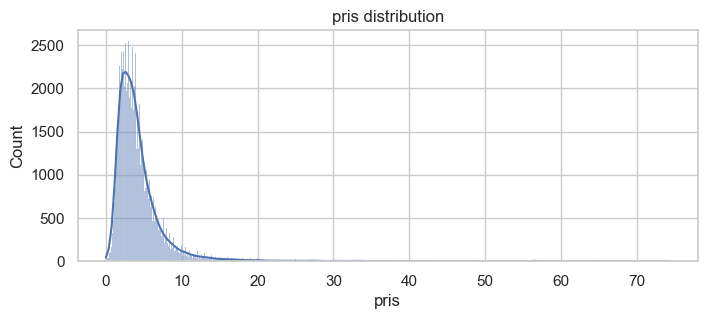

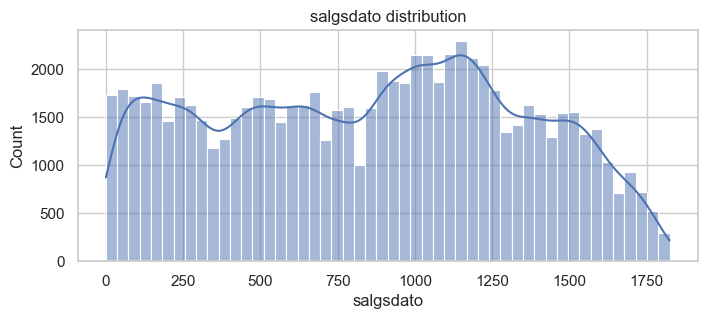

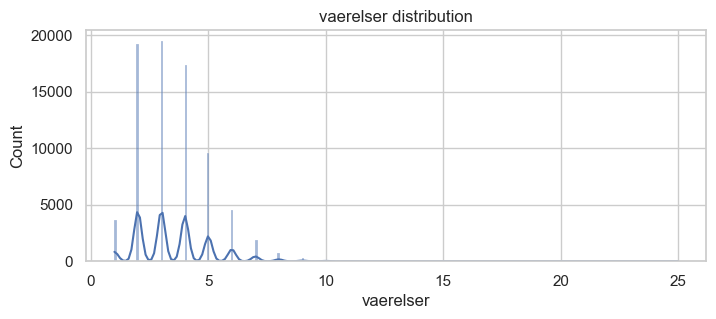

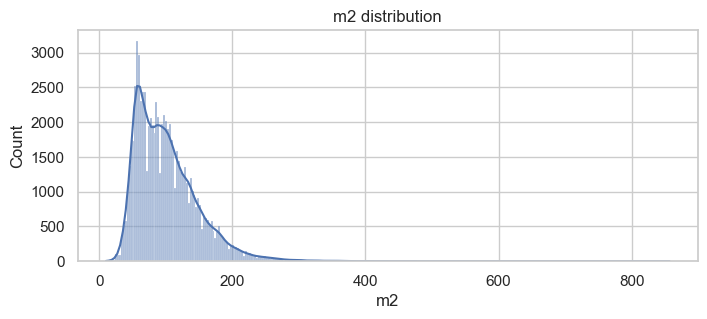

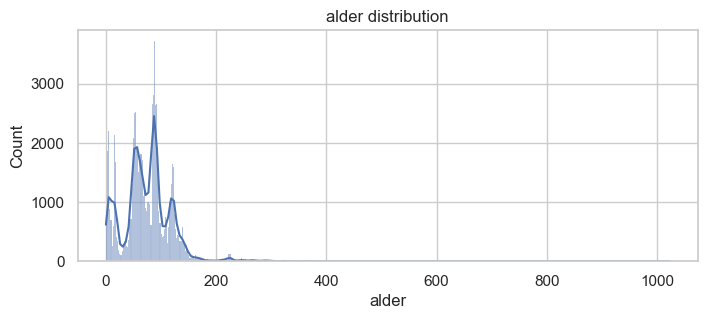

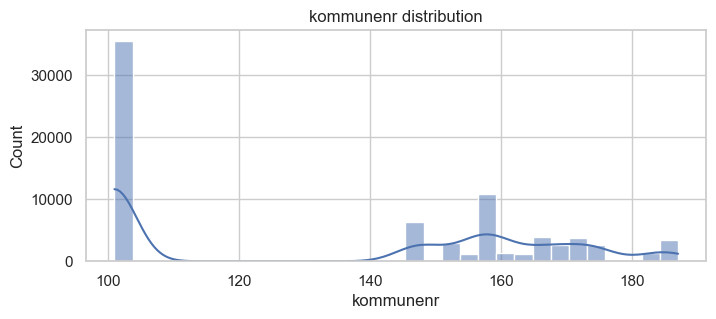

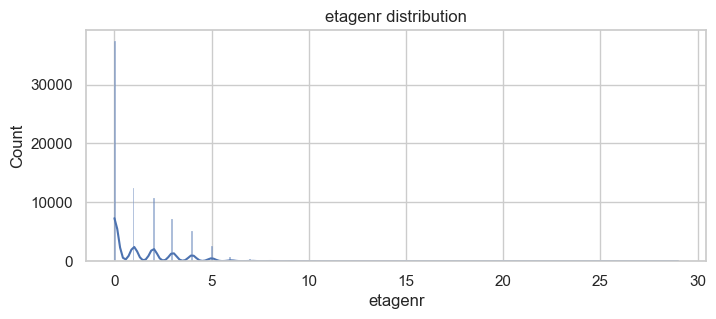

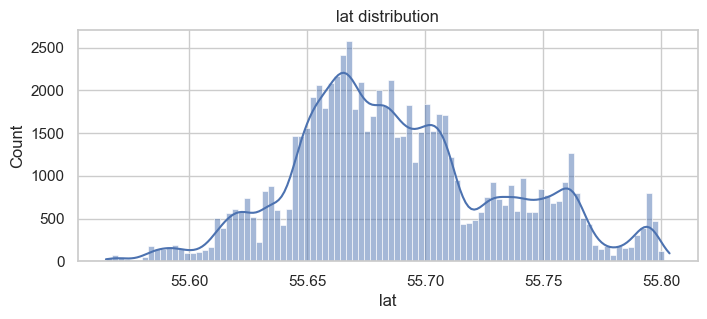

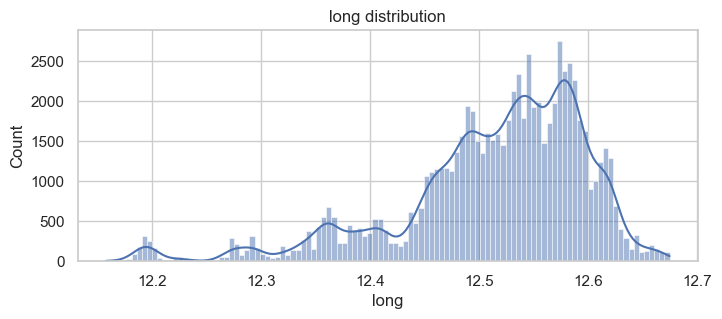

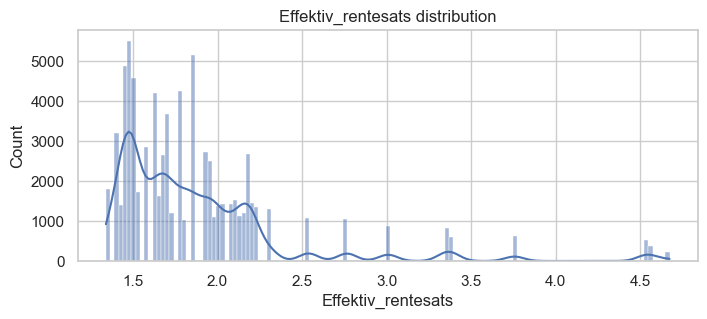

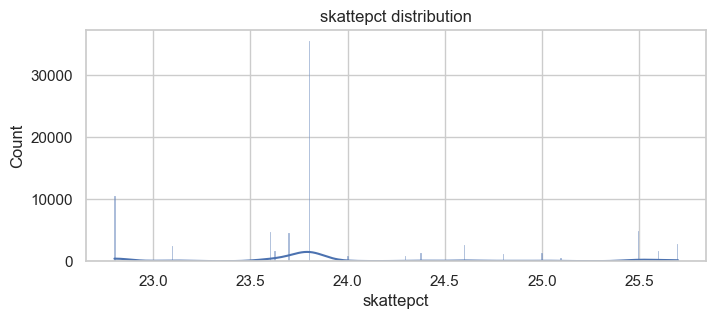

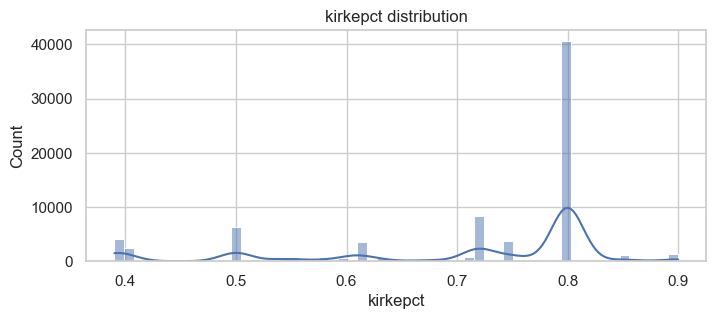

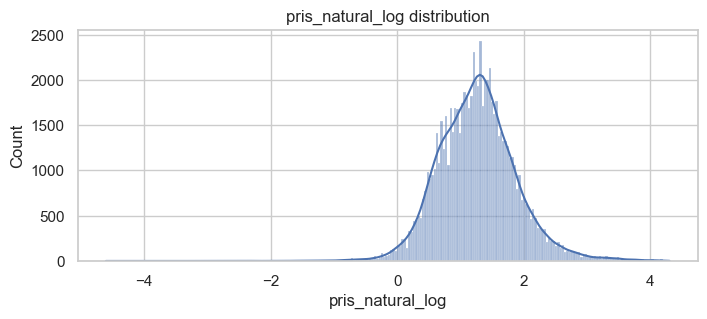

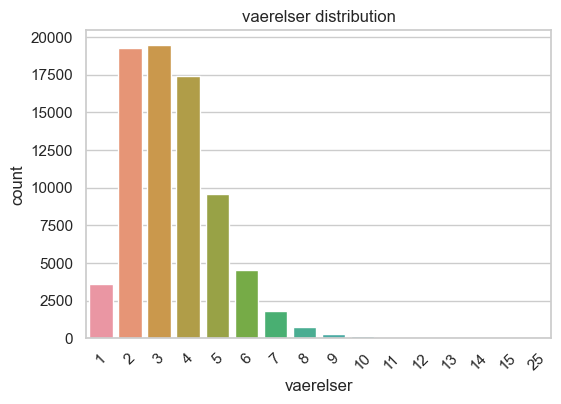


Frekvenstabel for vaerelser:
    vaerelser  Frequency
0           3      19471
1           2      19259
2           4      17410
3           5       9607
4           6       4560
5           1       3613
6           7       1845
7           8        733
8           9        262
9          10        123
10         11         41
11         12         27
12         13          8
13         14          5
14         15          1
15         25          1


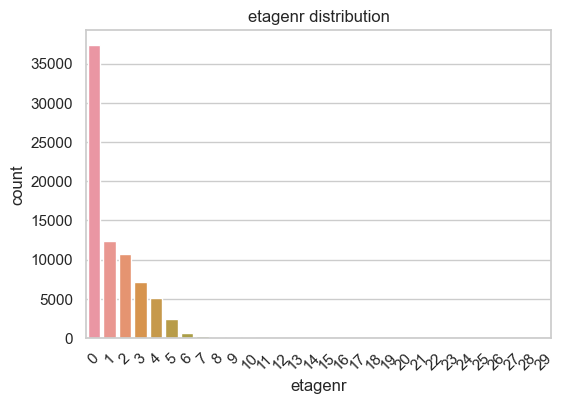


Frekvenstabel for etagenr:
    etagenr  Frequency
0         0      37382
1         1      12417
2         2      10717
3         3       7139
4         4       5164
5         5       2502
6         6        717
7         7        326
8         8        137
9         9        137
10       10         87
11       12         50
12       11         49
13       13         45
14       14         26
15       15         19
16       16          9
17       24          6
18       22          5
19       20          4
20       17          4
21       23          4
22       19          4
23       26          3
24       21          3
25       25          3
26       18          3
27       29          2
28       27          1
29       28          1


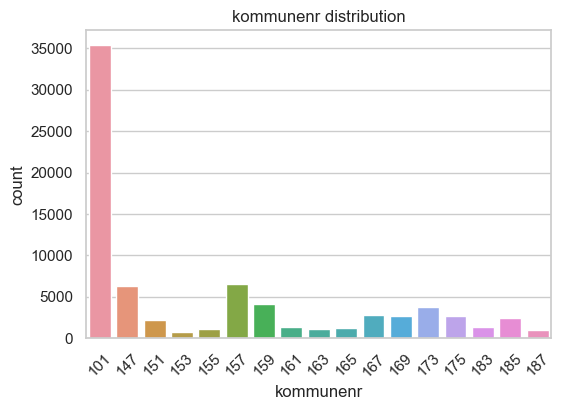


Frekvenstabel for kommunenr:
    kommunenr  Frequency
0         101      35423
1         157       6590
2         147       6294
3         159       4181
4         173       3806
5         167       2754
6         175       2686
7         169       2658
8         185       2486
9         151       2152
10        161       1405
11        183       1294
12        165       1202
13        155       1157
14        163       1154
15        187        948
16        153        776


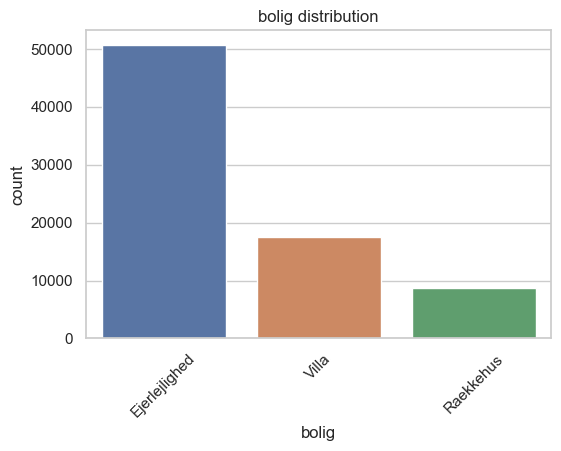


Frekvenstabel for bolig:
           bolig  Frequency
0  Ejerlejlighed      50698
1          Villa      17492
2      Raekkehus       8776


In [12]:
#df['vaerelser'] = pd.Categorical(df['vaerelser'])
#df['etagenr'] = pd.Categorical(df['etagenr'])
#df['kommunenr'] = pd.Categorical(df['kommunenr'])

numerical_features = df.select_dtypes(include=['int64', 'float64'])
numerical_stats = numerical_features.describe()
print("Numeriske variable:")
print(numerical_stats)

# Deskriptiv statistik for kategoriske variabler
categorical_features = df.select_dtypes(include=['object'])
categorical_features = df.loc[:,['vaerelser','etagenr','kommunenr','bolig']]
categorical_stats = categorical_features.describe()
print("\nKategoriske variable:")#
print(categorical_stats)

# Visualisering af numeriske variable
sns.set(style="whitegrid")

for column in numerical_features.columns:
    plt.figure(figsize=(8, 3))
    sns.histplot(data=numerical_features, x=column, kde=True)
    plt.title(f'{column} distribution')
    plt.show()

# Visualisering af kategoriske variable
for column in categorical_features.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=categorical_features, x=column)
    plt.title(f'{column} distribution')
    plt.xticks(rotation=45)
    plt.show()
    freq_table = categorical_features[column].value_counts().reset_index()
    freq_table.columns = [column, 'Frequency']
    print(f"\nFrekvenstabel for {column}:")
    print(freq_table)

In [ ]:
from IPython.display import display


center_latitude = df['lat'].mean()
center_longitude = df['long'].mean()

# Opret et kort centreret omkring midtpunktet
my_map = folium.Map(location=[center_latitude, center_longitude], zoom_start=10)


# Tilføj ejendomsmarkører til kortet som prikker
for index, row in df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=1,  # Du kan justere radius efter dine behov
        popup=f"Pris: {row['pris']}",
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.3,
    ).add_to(my_map)

# Vis kortet
my_map

# Converting the dates into a numerical variable 
In this example, the "salesdate" column is converted to a datetime type and features are extracted from the date (year, month, and day of the week). The day of the week is then one-hot encoded into binary variables. The resulting dataframe now only contains numerical features, which can be used to train the XGBoost model.

XGBoost can handle dates, but they need to be converted into a numerical representation first. One common approach to handle dates is to extract features from the date and use them as input variables. For example, you could extract the day of the week, month, year, or day of the year from the date and use them as separate input variables.

In [4]:
# Convert to datetime format
df['salgsdato'] = pd.to_datetime(df['salgsdato'])

# Calculate the number of seconds since a reference date
reference_date = df['salgsdato'].min()
df['salgsdato'] = (df['salgsdato'] - reference_date).dt.days
#df['salgsdato'] = (df['salgsdato'] - reference_date).dt.days

In [5]:
df

,pris,salgsdato,bolig,vaerelser,m2,alder,kommunenr,etagenr,lat,long,Effektiv_rentesats,skattepct,kirkepct
0,1400000.0,363,Ejerlejlighed,2,47,83,101,0,55.661452,12.481858,1.847,23.8,0.80
1,3260000.0,363,Ejerlejlighed,3,102,98,101,0,55.675067,12.488933,1.847,23.8,0.80
2,2925000.0,363,Ejerlejlighed,3,60,121,101,4,55.665333,12.609254,1.847,23.8,0.80
3,3850000.0,363,Ejerlejlighed,4,90,4,101,0,55.653147,12.565558,1.847,23.8,0.80
4,3925000.0,361,Ejerlejlighed,3,128,34,101,1,55.705130,12.530371,1.847,23.8,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84129,3450000.0,15,Raekkehus,5,110,74,185,0,55.633314,12.615673,1.936,23.1,0.61
84130,3700000.0,8,Raekkehus,6,128,62,185,0,55.636315,12.616112,1.936,23.1,0.61
84131,3595000.0,5,Raekkehus,5,128,47,185,0,55.609412,12.582477,1.936,23.1,0.61
84132,3448000.0,3,Raekkehus,4,90,65,185,0,55.621610,12.615738,1.936,23.1,0.61


# Standardizing the numerical an integer values in the dataset
In this example, the StandardScaler is fit to the numerical features using the fit method, and then used to transform the numerical features using the transform method. The standardized data is now stored in the dataframe and ready to be used for training the XGBoost model.

Whether to standardize the data before using XGBoost depends on the nature of the data and the specific use case.

Standardizing the data means transforming the numerical features to have a mean of 0 and a standard deviation of 1. This can be useful when using algorithms like XGBoost, which use distance metrics to make predictions, because it ensures that all features are on a similar scale and thus contributes equally to the predictions.

However, not all data requires standardization, and in some cases it may not improve the performance of the model. For example, if the features already have similar ranges or distributions, there may not be a need to standardize them.

In general, it is recommended to try both standardizing and not standardizing the data, and compare the performance of the model to see which one works better.

In [179]:
# Select the numerical features to be standardized
numerical_features = ["salgsdato","vaerelser","alder","etagenr","m2","lat","long","Effektiv_rentesats", "skattepct", "kirkepct"]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the StandardScaler to the numerical features
scaler.fit(df[numerical_features])

# Transform the numerical features
df[numerical_features] = scaler.transform(df[numerical_features])
# The standardized data is now stored in the dataframe


In [180]:
df

,pris,salgsdato,bolig,vaerelser,m2,alder,kommunenr,etagenr,lat,long,Effektiv_rentesats,skattepct,kirkepct
0,1400000.0,-0.986439,Ejerlejlighed,-0.949336,-1.128562,0.190860,101,-0.747923,-0.618377,-0.332971,-0.045205,-0.166370,0.653197
1,3260000.0,-0.986439,Ejerlejlighed,-0.294174,0.045896,0.533125,101,-0.747923,-0.310227,-0.253334,-0.045205,-0.166370,0.653197
2,2925000.0,-0.986439,Ejerlejlighed,-0.294174,-0.850963,1.057931,101,1.486152,-0.530537,1.101024,-0.045205,-0.166370,0.653197
3,3850000.0,-0.986439,Ejerlejlighed,0.360988,-0.210350,-1.611735,101,-0.747923,-0.806345,0.609173,-0.045205,-0.166370,0.653197
4,3925000.0,-0.990524,Ejerlejlighed,-0.294174,0.601094,-0.927205,101,-0.189404,0.370193,0.213101,-0.045205,-0.166370,0.653197
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84129,3450000.0,-1.697239,Raekkehus,1.016150,0.216726,-0.014499,185,-0.747923,-1.255228,1.173278,0.122535,-1.064837,-0.735209
84130,3700000.0,-1.711537,Raekkehus,1.671312,0.601094,-0.288311,185,-0.747923,-1.187306,1.178219,0.122535,-1.064837,-0.735209
84131,3595000.0,-1.717665,Raekkehus,1.016150,0.601094,-0.630576,185,-0.747923,-1.796205,0.799617,0.122535,-1.064837,-0.735209
84132,3448000.0,-1.721750,Raekkehus,0.360988,-0.210350,-0.219858,185,-0.747923,-1.520126,1.174010,0.122535,-1.064837,-0.735209


# Creating binary variables from the categorical variables

In [6]:
# Convert categorical variables into binary variables
df = pd.get_dummies(df, columns=['bolig','kommunenr'])

In [7]:
# Check the data frame
df['pris']=df['pris']/1000000

In [8]:
df

,pris,salgsdato,vaerelser,m2,alder,etagenr,lat,long,Effektiv_rentesats,skattepct,...,kommunenr_161,kommunenr_163,kommunenr_165,kommunenr_167,kommunenr_169,kommunenr_173,kommunenr_175,kommunenr_183,kommunenr_185,kommunenr_187
0,1.400,363,2,47,83,0,55.661452,12.481858,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
1,3.260,363,3,102,98,0,55.675067,12.488933,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
2,2.925,363,3,60,121,4,55.665333,12.609254,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
3,3.850,363,4,90,4,0,55.653147,12.565558,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
4,3.925,361,3,128,34,1,55.705130,12.530371,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84129,3.450,15,5,110,74,0,55.633314,12.615673,1.936,23.1,...,0,0,0,0,0,0,0,0,1,0
84130,3.700,8,6,128,62,0,55.636315,12.616112,1.936,23.1,...,0,0,0,0,0,0,0,0,1,0
84131,3.595,5,5,128,47,0,55.609412,12.582477,1.936,23.1,...,0,0,0,0,0,0,0,0,1,0
84132,3.448,3,4,90,65,0,55.621610,12.615738,1.936,23.1,...,0,0,0,0,0,0,0,0,1,0


### Removing duplicates

In [5]:
# remove duplicates based on a subset of columns
subset_cols = ['pris','salgsdato','lat','long']
df = df.drop_duplicates(subset=subset_cols)

# print the resulting DataFrame
df

,pris,salgsdato,bolig,vaerelser,m2,alder,kommunenr,etagenr,lat,long,Effektiv_rentesats,skattepct,kirkepct
0,1400000.0,363,Ejerlejlighed,2,47,83,101,0,55.661452,12.481858,1.847,23.8,0.80
1,3260000.0,363,Ejerlejlighed,3,102,98,101,0,55.675067,12.488933,1.847,23.8,0.80
2,2925000.0,363,Ejerlejlighed,3,60,121,101,4,55.665333,12.609254,1.847,23.8,0.80
3,3850000.0,363,Ejerlejlighed,4,90,4,101,0,55.653147,12.565558,1.847,23.8,0.80
4,3925000.0,361,Ejerlejlighed,3,128,34,101,1,55.705130,12.530371,1.847,23.8,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84129,3450000.0,15,Raekkehus,5,110,74,185,0,55.633314,12.615673,1.936,23.1,0.61
84130,3700000.0,8,Raekkehus,6,128,62,185,0,55.636315,12.616112,1.936,23.1,0.61
84131,3595000.0,5,Raekkehus,5,128,47,185,0,55.609412,12.582477,1.936,23.1,0.61
84132,3448000.0,3,Raekkehus,4,90,65,185,0,55.621610,12.615738,1.936,23.1,0.61


### Remove Outliers

/var/folders/xw/6wtx1hgx6slbjzfgny44003w0000gn/T/ipykernel_40696/2578092084.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['pris'])


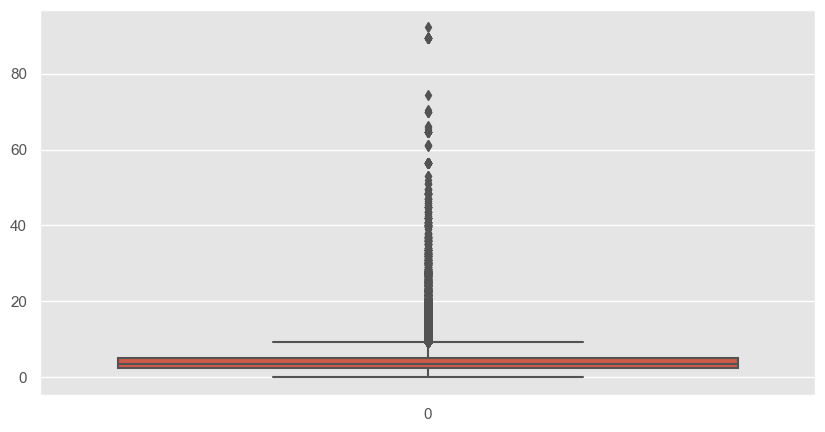

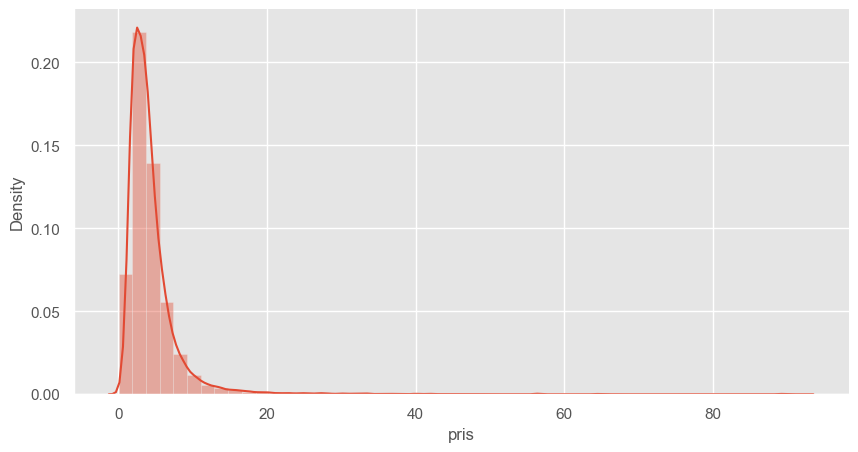

In [43]:
plt.figure(figsize=(10,5))
sns.boxplot(df['pris'])
plt.show

plt.figure(figsize=(10,5))
sns.distplot(df['pris'])
sns.despine()
plt.show()

/var/folders/xw/6wtx1hgx6slbjzfgny44003w0000gn/T/ipykernel_32391/1121137672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df[field_name]>(igr+np.percentile(df[field_name],75))].index, inplace=True)
/var/folders/xw/6wtx1hgx6slbjzfgny44003w0000gn/T/ipykernel_32391/1121137672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df[field_name]<(np.percentile(df[field_name],25)-igr)].index, inplace=True)


<function matplotlib.pyplot.show(close=None, block=None)>

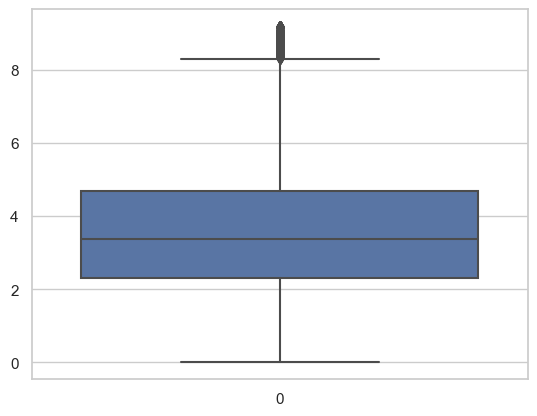

In [17]:
def drop_outliers(df,field_name):
    igr= 1.5*(np.percentile(df[field_name],75)-np.percentile(df[field_name],25))
    df.drop(df[df[field_name]>(igr+np.percentile(df[field_name],75))].index, inplace=True)
    df.drop(df[df[field_name]<(np.percentile(df[field_name],25)-igr)].index, inplace=True)

drop_outliers(df, 'pris')

In [44]:
mean = df['pris'].mean()
std_dev = df['pris'].std()

# Definer grænserne for outliers
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

# Filtrer DataFrame for at fjerne outliers i kolonne A
df = df[(df['pris'] >= lower_bound) & (df['pris'] <= upper_bound)]

In [45]:
df.max(axis=0)

pris                     16.850000
salgsdato              1824.000000
vaerelser                25.000000
m2                      857.000000
alder                  1023.000000
etagenr                  29.000000
lat                      55.801546
long                     12.674650
Effektiv_rentesats        4.675000
skattepct                25.700000
kirkepct                  0.900000
bolig_Ejerlejlighed       1.000000
bolig_Raekkehus           1.000000
bolig_Villa               1.000000
kommunenr_101             1.000000
kommunenr_147             1.000000
kommunenr_151             1.000000
kommunenr_153             1.000000
kommunenr_155             1.000000
kommunenr_157             1.000000
kommunenr_159             1.000000
kommunenr_161             1.000000
kommunenr_163             1.000000
kommunenr_165             1.000000
kommunenr_167             1.000000
kommunenr_169             1.000000
kommunenr_173             1.000000
kommunenr_175             1.000000
kommunenr_183       

<function matplotlib.pyplot.show(close=None, block=None)>

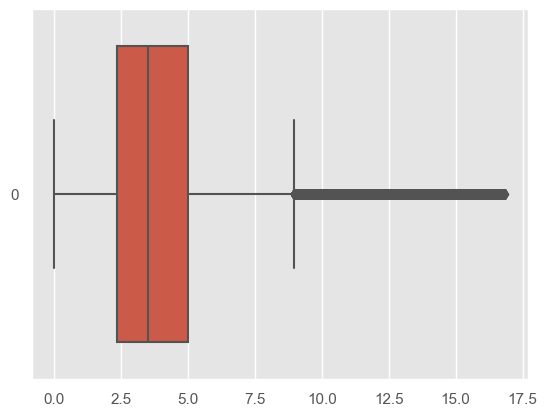

In [46]:
sns.boxplot(df['pris'], orient='h')
plt.show

In [47]:
df

,pris,salgsdato,vaerelser,m2,alder,etagenr,lat,long,Effektiv_rentesats,skattepct,...,kommunenr_161,kommunenr_163,kommunenr_165,kommunenr_167,kommunenr_169,kommunenr_173,kommunenr_175,kommunenr_183,kommunenr_185,kommunenr_187
0,1.400,363,2,47,83,0,55.661452,12.481858,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
1,3.260,363,3,102,98,0,55.675067,12.488933,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
2,2.925,363,3,60,121,4,55.665333,12.609254,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
3,3.850,363,4,90,4,0,55.653147,12.565558,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
4,3.925,361,3,128,34,1,55.705130,12.530371,1.847,23.8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84129,3.450,15,5,110,74,0,55.633314,12.615673,1.936,23.1,...,0,0,0,0,0,0,0,0,1,0
84130,3.700,8,6,128,62,0,55.636315,12.616112,1.936,23.1,...,0,0,0,0,0,0,0,0,1,0
84131,3.595,5,5,128,47,0,55.609412,12.582477,1.936,23.1,...,0,0,0,0,0,0,0,0,1,0
84132,3.448,3,4,90,65,0,55.621610,12.615738,1.936,23.1,...,0,0,0,0,0,0,0,0,1,0


### Log transform

In [10]:
df['pris_natural_log'] = np.log(df['pris'])

/var/folders/xw/6wtx1hgx6slbjzfgny44003w0000gn/T/ipykernel_81276/2051281227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pris_natural_log'] = np.log(df['pris'])


In [11]:
df

,pris,salgsdato,bolig,vaerelser,m2,alder,kommunenr,etagenr,lat,long,Effektiv_rentesats,skattepct,kirkepct,pris_natural_log
0,1.400,363,Ejerlejlighed,2,47,83,101,0,55.661452,12.481858,1.847,23.8,0.80,0.336472
1,3.260,363,Ejerlejlighed,3,102,98,101,0,55.675067,12.488933,1.847,23.8,0.80,1.181727
2,2.925,363,Ejerlejlighed,3,60,121,101,4,55.665333,12.609254,1.847,23.8,0.80,1.073294
3,3.850,363,Ejerlejlighed,4,90,4,101,0,55.653147,12.565558,1.847,23.8,0.80,1.348073
4,3.925,361,Ejerlejlighed,3,128,34,101,1,55.705130,12.530371,1.847,23.8,0.80,1.367366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84129,3.450,15,Raekkehus,5,110,74,185,0,55.633314,12.615673,1.936,23.1,0.61,1.238374
84130,3.700,8,Raekkehus,6,128,62,185,0,55.636315,12.616112,1.936,23.1,0.61,1.308333
84131,3.595,5,Raekkehus,5,128,47,185,0,55.609412,12.582477,1.936,23.1,0.61,1.279544
84132,3.448,3,Raekkehus,4,90,65,185,0,55.621610,12.615738,1.936,23.1,0.61,1.237794


# Feature Importance 
There are several methods you can use to determine which variables are most relevant for your prediction model:

- Correlation Analysis: You can calculate the correlation between each variable and the dependent variable (in this case, "price") and include only the variables with the highest correlation.

- Feature Importance: You can use the feature importance scores provided by the XGBoost model (or any other machine learning model) to determine which variables are most important in your prediction.

- Recursive Feature Elimination (RFE): You can use the RFE method to eliminate the least important variables one by one and determine the optimal number of variables to include in your model.

- Lasso Regression: You can use Lasso Regression, which is a type of linear regression that includes a regularization term, to determine which variables are most important in your prediction.

- Principal Component Analysis (PCA): You can use PCA to reduce the dimensionality of your data and identify the most important variables in your prediction.

It is often a good idea to use a combination of these methods to get the most accurate results. It is also important to keep in mind that the relevance of the variables can vary depending on the location and time period of the data. Therefore, it is important to carefully analyze your data and perform feature selection and engineering to determine which variables are most relevant and useful for your prediction model.

# example of calculating the distance from puplic transportation

In [169]:
## example of calculating the distance from puplic transportation
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Example usage:
lat1, lon1 = 51.5074, -0.1278
lat2, lon2 = 40.7128, -74.0060
distance = haversine_distance(lat1, lon1, lat2, lon2)
print(distance, "kilometers")

5570.222179737958 kilometers


## Regressiontree

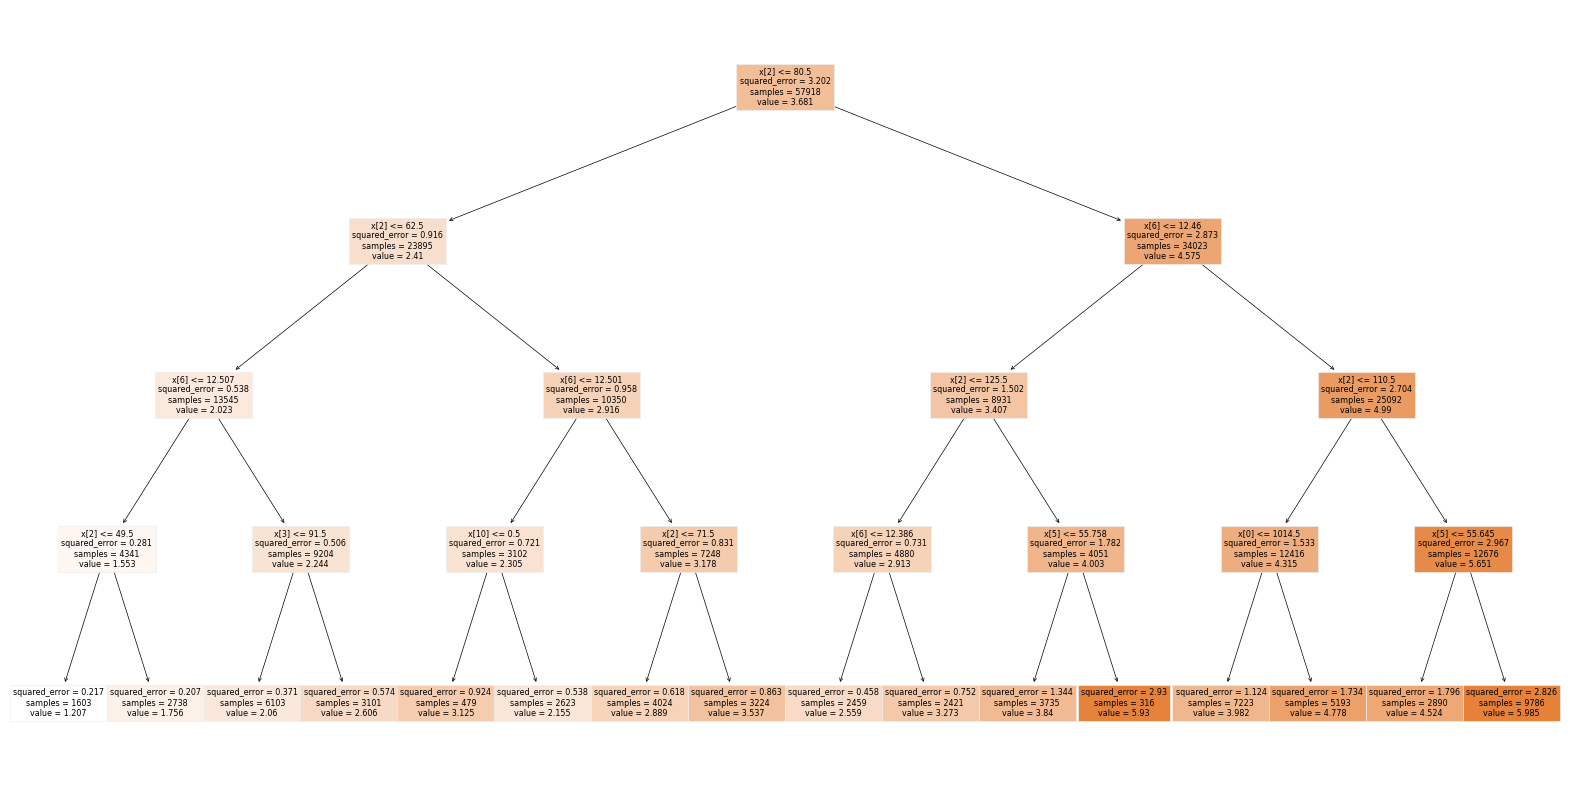

MSE:  1.2899478092158567
RMSE:  1.135758693216062


In [13]:
X = df.drop("pris", axis=1)
y = df["pris"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# Fit a regression tree to the data
tree = DecisionTreeRegressor(max_depth=4)
tree.fit(X_train, y_train)

# Visualize the tree using graphviz
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=X_train.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
#graph.render('tree_visualization')  

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True)
plt.show()

y_pred = tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse)
print('RMSE: ', np.sqrt(mse))


In [14]:
X_train.columns

Index(['salgsdato', 'vaerelser', 'm2', 'alder', 'etagenr', 'lat', 'long',
       'Effektiv_rentesats', 'skattepct', 'kirkepct', 'bolig_Ejerlejlighed',
       'bolig_Raekkehus', 'bolig_Villa', 'kommunenr_101', 'kommunenr_147',
       'kommunenr_151', 'kommunenr_153', 'kommunenr_155', 'kommunenr_157',
       'kommunenr_159', 'kommunenr_161', 'kommunenr_163', 'kommunenr_165',
       'kommunenr_167', 'kommunenr_169', 'kommunenr_173', 'kommunenr_175',
       'kommunenr_183', 'kommunenr_185', 'kommunenr_187'],
      dtype='object')

# Class Of Predicting The Housing Prices with the three methods, Random Forest, Gradient Boosting and XGBoosting

In [10]:
class PredictingHousingPrices:
    def __init__(self, X, y, cross_val, model, visualize):
        self.X = X
        self.y = y
        self.cross_val = cross_val
        self.model = model
        self.visualize = visualize

    def create_train_test(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=19)
    
    def RandomForest(self):
        rf = RandomForestRegressor(random_state=0)

        param_grid = {'n_estimators': [2700],# 300, 500],
                    'max_depth': [28],#3, 4, 5],
        }

        grid_search = GridSearchCV(rf, param_grid, cv=self.cross_val, scoring='neg_mean_squared_error')
        grid_search.fit(self.X_train, self.y_train)
        self.best_params = grid_search.best_params_
        best_rf = grid_search.best_estimator_
        self.feature_importances = best_rf.feature_importances_
        y_pred = grid_search.predict(self.X_test)
        self.mse = mean_squared_error(self.y_test, y_pred)

        self.mean_fit_times = grid_search.cv_results_['mean_fit_time']
        self.std_fit_times = grid_search.cv_results_['std_fit_time']
        self.mean_score_times = grid_search.cv_results_['mean_score_time']
        self.std_score_times = grid_search.cv_results_['std_score_time']
        self.n_estimators = param_grid['n_estimators']  
        new_list_n_est = []

        new_list_n_est = self.n_estimators * int(len(self.mean_fit_times)/len(self.n_estimators))
        self.time_per_tree = self.mean_fit_times / new_list_n_est


        print("\nRandom Forest:")
        self.print_output()

        for i, params in enumerate(grid_search.cv_results_['params']):
            print(f"Parameters: {params}")
            print(f"Time per tree: {self.time_per_tree[i]}")
            print(f"Mean fit time: {self.mean_fit_times[i]}")

        residuals = self.y_test - y_pred
        plt.figure(figsize=(8,5))
        plt.scatter(y_pred, residuals)
        plt.title('Residual Plot: Random Forest Regression')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.show()

        df_fit_res = pd.DataFrame({'residualer': residuals, 'fitted værdier': y_pred})
        df_fit_res.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/rf_df_res_fit.csv', encoding='utf-8')

    def GradientBoosting(self):
        gb = GradientBoostingRegressor(random_state=19)

        param_grid = {'n_estimators': [600],#100, 300, 500],
                    'max_depth': [8],#3, 4, 5],
                    'learning_rate': [0.1],# 0.05, 0.01],
                    }

        grid_search = GridSearchCV(gb, param_grid, cv=self.cross_val, scoring='neg_mean_squared_error')
        grid_search.fit(self.X_train, self.y_train)
        self.best_params = grid_search.best_params_

        y_pred = grid_search.predict(self.X_test)
        self.mse = mean_squared_error(self.y_test, y_pred)
        best_gb = grid_search.best_estimator_
        self.feature_importances = best_gb.feature_importances_

        self.mean_fit_times = grid_search.cv_results_['mean_fit_time']
        self.std_fit_times = grid_search.cv_results_['std_fit_time']
        self.mean_score_times = grid_search.cv_results_['mean_score_time']
        self.std_score_times = grid_search.cv_results_['std_score_time']
        self.n_estimators = param_grid['n_estimators']  
        new_list_n_est = []

        new_list_n_est = self.n_estimators * int(len(self.mean_fit_times)/len(self.n_estimators))
        self.time_per_tree = self.mean_fit_times / new_list_n_est


        print("\nGradient Boosting:")
        self.print_output()

        for i, params in enumerate(grid_search.cv_results_['params']):
            print(f"Parameters: {params}")
            print(f"Time per tree: {self.time_per_tree[i]}")
            print(f"Mean fit time: {self.mean_fit_times[i]}")

        residuals = self.y_test - y_pred
        #plt.figure(figsize=(8,5))
        #plt.scatter(y_pred, residuals)
        #plt.title('Residual Plot: Gradient Boosting Regression')
        #plt.xlabel('Predicted Values')
        #plt.ylabel('Residuals')
        #plt.axhline(y=0, color='r', linestyle='-')
        #plt.show()

        df_fit_res = pd.DataFrame({'residualer': residuals, 'fitted værdier': y_pred})
        df_fit_res.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/gb_df_res_fit.csv', encoding='utf-8')
        
    def XGBoost(self):
        xgb = XGBRegressor(random_state=19)
    
        param_grid = {'n_estimators': [1000],#600, 700, 800, 900],
            'learning_rate': [0.1],#, 0.3, 0.4],
            'max_depth': [8],# 6, 7, 8], 
        }

        grid_search = GridSearchCV(xgb, param_grid, cv=self.cross_val, scoring='neg_mean_squared_error')
        grid_search.fit(self.X_train, self.y_train)
        self.best_params = grid_search.best_params_
        self.y_pred = grid_search.predict(self.X_test)
        self.mse = mean_squared_error(self.y_test, self.y_pred)
        best_xgb = grid_search.best_estimator_
        self.feature_importances = best_xgb.feature_importances_

        self.mean_fit_times = grid_search.cv_results_['mean_fit_time']
        self.std_fit_times = grid_search.cv_results_['std_fit_time']
        self.mean_score_times = grid_search.cv_results_['mean_score_time']
        self.std_score_times = grid_search.cv_results_['std_score_time']
        self.n_estimators = param_grid['n_estimators']  
        new_list_n_est = []

        new_list_n_est = self.n_estimators * int(len(self.mean_fit_times)/len(self.n_estimators))
        self.time_per_tree = self.mean_fit_times / new_list_n_est

        
        print("\nXGBoost:")
        self.print_output()

        #results = pd.DataFrame(grid_search.cv_results_)
        #print(results)

        for i, params in enumerate(grid_search.cv_results_['params']):
            print(f"Parameters: {params}")
            print(f"Time per tree: {self.time_per_tree[i]}")
            print(f"Mean fit time: {self.mean_fit_times[i]}")

        residuals = self.y_test - self.y_pred
        #plt.figure(figsize=(8,5))
        #plt.scatter(self.y_pred, residuals)
        #plt.title('Residual Plot: XGBoost Regression')
        #plt.xlabel('Predicted Values')
        #plt.ylabel('Residuals')
        #plt.axhline(y=0, color='r', linestyle='-')
        #plt.show()

        #save 
        df_fit_res = pd.DataFrame({'residualer': residuals, 'fitted værdier': self.y_pred})
        df_fit_res.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/df_res_fit.csv', encoding='utf-8')
        

    def plot_learning_curves(self):
        train_sizes, train_scores, test_scores = learning_curve(self.mod, self.X, self.y, cv=self.cross_val, scoring='neg_mean_squared_error',train_sizes=np.linspace(0.1, 1, 10), random_state=0)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
        plt.plot(train_sizes, train_scores_mean, 'o-', color='r',label='Training score')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='g',label='Cross-validation score')
        plt.legend(loc='best')
        
    def visualization(self):
        if self.model == "RF":
            self.mod = RandomForestRegressor(random_state=0)
            plt.figure(figsize=(10, 5))
            self.plot_learning_curves()
        elif self.model == "GB":
            self.mod = GradientBoostingRegressor(random_state=0)
            plt.figure(figsize=(10, 5))
            self.plot_learning_curves()
        elif self.model == "XGB":
            self.mod = XGBRegressor(random_state=0)
            plt.figure(figsize=(10, 5))
            self.plot_learning_curves()
        elif self.model == "ALL":
            plt.figure(figsize=(10, 5))
            self.mod = RandomForestRegressor(random_state=0)
            plt.subplot(1, 3, 1)
            self.plot_learning_curves()
            plt.title('Random Forest')
            self.mod = GradientBoostingRegressor(random_state=0)
            plt.subplot(1, 3, 2)
            self.plot_learning_curves()
            plt.title('Gradient Boosting')
            self.mod = XGBRegressor(random_state=0)
            plt.subplot(1, 3, 3)
            self.plot_learning_curves()
            plt.title('XGBoost')
            plt.tight_layout()
            plt.show()
    
    def print_output(self):
        print("Best hyperparameters:\n", self.best_params)
        print(f"MSE: {self.mse}")
        print("RMSE:", np.sqrt(self.mse))
        print("Feature Importances:\n", self.feature_importances)
        

    def run(self):
        self.create_train_test()
        if self.model == "RF":
            print("\nRandom Forest Algorithm running...")
            self.RandomForest()
            print("\nDone!")
        elif self.model == "GB":
            print("\nGradient Boosting Algorithm running...")
            self.GradientBoosting()
            print("\nDone!")
        elif self.model == "XGB":
            print("\nXGBoost Algorithm running...")
            self.XGBoost()
            print("\nDone!")
        elif self.model =="ALL":
            print("\nRandom Forest Algorithm running...")
            self.RandomForest()
            print("\nGradient Boosting Algorithm running...")
            self.GradientBoosting()
            print("\nXGBoost Algorithm running...")
            self.XGBoost()
            print("\nDone!")
        else:
            print("Please choose a model: Random Forest (RF), Gradient Boosting (GB), XGBoost (XGB), or All three models (ALL)")
        
        if self.visualize:
            print("Plotting...")
            self.visualization()



In [10]:
#X = df.drop(["pris","pris_natural_log"], axis=1)
#y = df["pris_natural_log"]

#X = filtered_df.drop(["pris"], axis=1)
#y = filtered_df["pris"]

X = df.drop(["pris"], axis=1)
y = df["pris"]


#HP = PredictingHousingPrices(X, y, 5, "RF", False)


Random Forest Algorithm running...

Random Forest:
Best hyperparameters:
 {'max_depth': 28, 'n_estimators': 2700}
MSE: 3.7753236123672997
RMSE: 1.9430192002055202
Feature Importances:
 [1.41597177e-01 1.60817494e-02 1.76852618e-01 2.41105048e-01
 8.33109520e-03 1.54489785e-01 1.57741817e-01 3.86644360e-02
 6.18129245e-03 2.39718002e-02 5.97485472e-03 2.12251446e-03
 3.34073732e-03 4.37347384e-03 6.56024557e-03 2.59663951e-04
 4.85351174e-04 1.29142087e-04 3.04470738e-03 3.22928996e-04
 3.81639517e-03 7.25590475e-04 3.01222695e-05 1.79216071e-04
 1.72807314e-03 4.28914992e-04 9.55675954e-04 7.76081557e-06
 3.96791957e-04 1.01021949e-04]
Parameters: {'max_depth': 28, 'n_estimators': 2700}
Time per tree: 0.2991562630158883
Mean fit time: 807.7219101428985


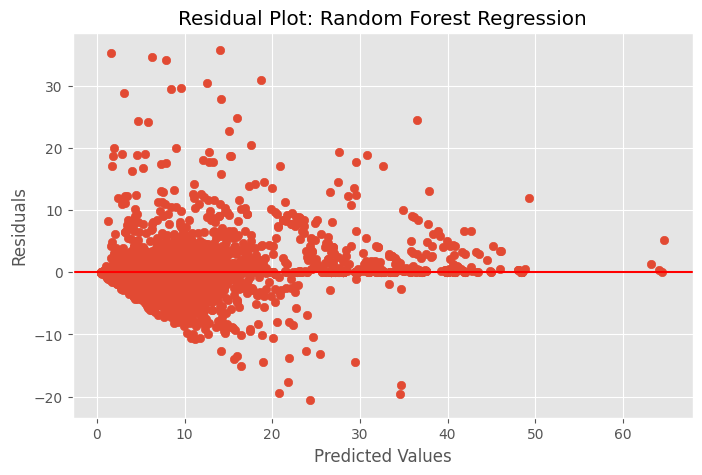


Done!


In [12]:
HP.run()


Random Forest Algorithm running...

Random Forest:
Best hyperparameters:
 {'max_depth': 31, 'n_estimators': 1600}
MSE: 0.09610315363138816
RMSE: 0.3100050864605098
Feature Importances:
 [6.73085315e-02 1.22239535e-02 5.01829371e-01 8.63277387e-02
 1.11564591e-02 9.34726257e-02 1.69793857e-01 2.09678744e-02
 4.19104745e-03 5.38292861e-03 8.64931263e-03 4.80193581e-03
 2.53905036e-03 2.26232100e-03 3.10792664e-03 9.48633499e-04
 2.94188446e-04 1.00578226e-04 8.72971084e-04 9.45348265e-04
 2.30657493e-04 3.16409490e-04 1.26589815e-04 2.22655527e-04
 5.57012219e-04 4.49321389e-04 2.45239320e-04 3.51839834e-05
 4.27287255e-04 2.12990529e-04]
Parameters: {'max_depth': 31, 'n_estimators': 1600}
Time per tree: 0.24484462285041808
Mean fit time: 391.7513965606689


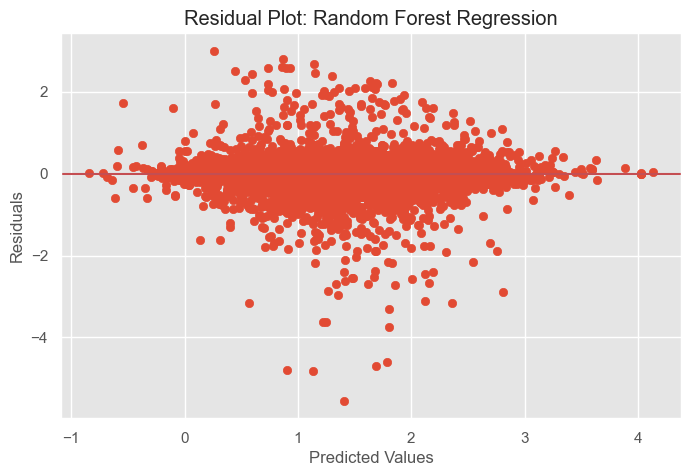


Done!


In [314]:
HP.run()

In [264]:
HP.run()


Gradient Boosting Algorithm running...

Gradient Boosting:
Best hyperparameters:
 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600}
MSE: 0.09027722769092494
RMSE: 0.3004616908874157
Feature Importances:
 [5.83829104e-02 1.00048851e-02 5.18919884e-01 8.12838657e-02
 7.11062299e-03 9.32949933e-02 1.75193665e-01 1.29948805e-02
 3.14207593e-03 8.47193654e-03 1.04694322e-02 3.95408305e-03
 2.50409837e-03 4.55018899e-03 3.65929506e-03 1.15443013e-03
 3.76477486e-04 5.15768135e-05 4.50905675e-04 6.68982520e-04
 2.43417661e-04 4.51576184e-04 1.01981710e-04 3.84206750e-04
 9.61895825e-04 2.83723119e-04 2.72463423e-04 5.52005078e-05
 5.13628455e-04 9.27169009e-05]
Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600}
Time per tree: 0.17061591609319052
Mean fit time: 102.36954965591431

Done!


In [212]:
HP.run()


XGBoost Algorithm running...

XGBoost:
Best hyperparameters:
 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}
MSE: 0.09008212389058219
RMSE: 0.3001368419414421
Feature Importances:
 [0.01219925 0.00905414 0.17762867 0.03314706 0.00902625 0.02538872
 0.04889914 0.00731543 0.01352956 0.03932035 0.10902612 0.02778189
 0.02698649 0.05429789 0.06365882 0.04745371 0.00991013 0.04403085
 0.         0.01106287 0.00826107 0.01478281 0.0120378  0.0075683
 0.15963393 0.01169205 0.         0.         0.00897709 0.00732963]
Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}
Time per tree: 0.041880089139938355
Mean fit time: 41.880089139938356

Done!


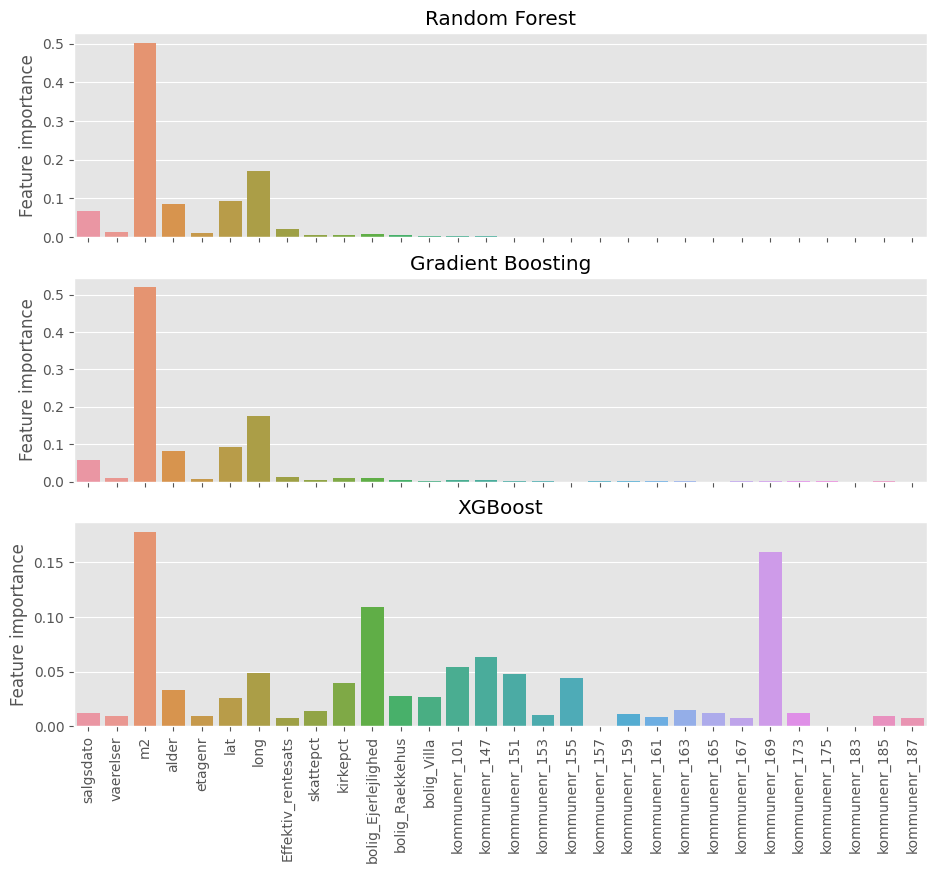

In [19]:
navne = X.columns

# Liste med værdier
rf_vaerdier = [6.73085315e-02, 1.22239535e-02, 5.01829371e-01, 8.63277387e-02,
 1.11564591e-02, 9.34726257e-02, 1.69793857e-01, 2.09678744e-02,
 4.19104745e-03, 5.38292861e-03, 8.64931263e-03, 4.80193581e-03,
 2.53905036e-03, 2.26232100e-03, 3.10792664e-03, 9.48633499e-04,
 2.94188446e-04, 1.00578226e-04, 8.72971084e-04, 9.45348265e-04,
 2.30657493e-04, 3.16409490e-04, 1.26589815e-04, 2.22655527e-04,
 5.57012219e-04, 4.49321389e-04, 2.45239320e-04, 3.51839834e-05,
 4.27287255e-04, 2.12990529e-04]

gb_vaerdier = [5.83829104e-02, 1.00048851e-02, 5.18919884e-01, 8.12838657e-02,
 7.11062299e-03, 9.32949933e-02, 1.75193665e-01, 1.29948805e-02,
 3.14207593e-03, 8.47193654e-03, 1.04694322e-02, 3.95408305e-03,
 2.50409837e-03, 4.55018899e-03, 3.65929506e-03, 1.15443013e-03,
 3.76477486e-04, 5.15768135e-05, 4.50905675e-04, 6.68982520e-04,
 2.43417661e-04, 4.51576184e-04, 1.01981710e-04, 3.84206750e-04,
 9.61895825e-04, 2.83723119e-04, 2.72463423e-04, 5.52005078e-05,
 5.13628455e-04, 9.27169009e-05]

xgb_vaerdier = [0.01219925, 0.00905414, 0.17762867, 0.03314706, 0.00902625, 0.02538872,
 0.04889914, 0.00731543, 0.01352956, 0.03932035, 0.10902612, 0.02778189,
 0.02698649, 0.05429789, 0.06365882, 0.04745371, 0.00991013, 0.04403085,
 0.        , 0.01106287, 0.00826107, 0.01478281, 0.0120378 , 0.0075683,
 0.15963393, 0.01169205, 0.        , 0.        , 0.00897709, 0.00732963]
#plt.figure(figsize=(10,3))
# Opret et bar plot
#sns.barplot(x=navne, y=vaerdier)

fig, axs = plt.subplots(3, 1, figsize=(11,9), sharex=True)

# Lav bar plots for hver subplot
model_list = [rf_vaerdier,gb_vaerdier,xgb_vaerdier]
model_name = ['Random Forest','Gradient Boosting','XGBoost']
for i in range(3):
    sns.barplot(x=navne, y=model_list[i], ax=axs[i])
    axs[i].set_ylabel('Feature importance')
    axs[i].set_title(model_name[i])

# Sæt titel og x-label på sidste subplot
#axs[2].set_title('Eksempel på Bar Plot')
#axs[2].set_xlabel('Variabel')

# Rotate x-tick labels for sidste subplot
for label in axs[2].get_xticklabels():
    label.set_rotation(90)

# Tilføj titler og aksebeskrivelser

#plt.title('Eksempel på Bar Plot')
#plt.xlabel('Variabel')
#plt.ylabel('Feature importance')

#ax = plt.gca()
#for label in ax.get_xticklabels():
#    label.set_rotation(90)
## Vis plot
#plt.show()


XGBoost Algorithm running...

XGBoost:
Best hyperparameters:
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
MSE: 0.09085236616113648
RMSE: 0.3014172625466838
Feature Importances:
 [0.01369748 0.00957655 0.20592186 0.03417066 0.0092619  0.0269113
 0.05615756 0.00683478 0.01529774 0.04409836 0.07144487 0.03522473
 0.02577263 0.04501298 0.07179776 0.05711165 0.00921919 0.00792219
 0.         0.01444438 0.01069376 0.01016869 0.00823709 0.00758884
 0.17752959 0.01237317 0.         0.         0.00702833 0.00650194]
Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
Time per tree: 0.04379001712799072
Mean fit time: 13.137005138397218


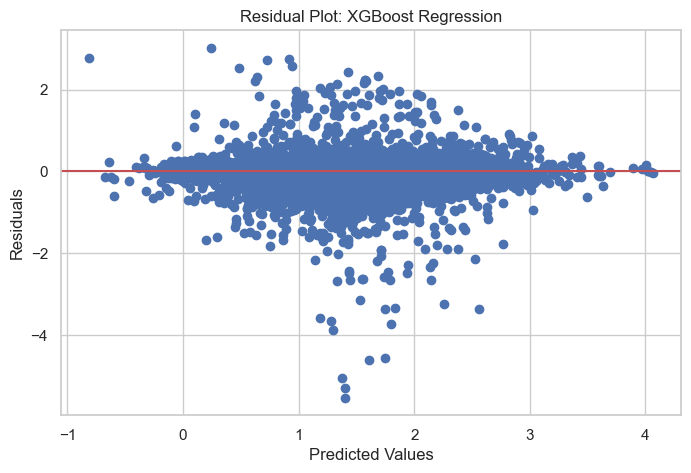


Done!


In [187]:
HP.run()

In [ ]:
HP.run()

#### Random Forest valuation plot

In [42]:
X = df.drop(["pris","pris_natural_log"], axis=1)
y = df["pris"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=19)

In [45]:
n_trees = np.arange(100,3100,100).tolist()
rf_val_errors_28 = []#gb_val_errors_6# rf_val_errors_27
for n in tqdm(n_trees):
    rf = RandomForestRegressor(n_estimators=n, max_depth=28, random_state=19)
    rf.fit(X_train, y_train)
    rf_val_errors_28.append(mean_squared_error(y_val, rf.predict(X_val)))

index_list = np.arange(100,3100,100).tolist()

rf_val_errors_df = pd.DataFrame({'max depth 28': rf_val_errors_28}, index=index_list)
rf_val_errors_df.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/final_results/rf_df_errors2.csv', encoding='utf-8')

100%|██████████| 30/30 [4:26:04<00:00, 532.15s/it]  


In [46]:
n_trees = np.arange(100,3100,100).tolist()
rf_val_errors_29 = []#gb_val_errors_6# rf_val_errors_27
for n in tqdm(n_trees):
    rf = RandomForestRegressor(n_estimators=n, max_depth=29, random_state=19)
    rf.fit(X_train, y_train)
    rf_val_errors_29.append(mean_squared_error(y_val, rf.predict(X_val)))
    
#index_list = np.arange(100,1100,100).tolist()

rf_val_errors_df['max depth 29'] = rf_val_errors_29
rf_val_errors_df.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/final_results/rf_df_errors2.csv', encoding='utf-8')


100%|██████████| 30/30 [4:30:22<00:00, 540.74s/it]  


In [47]:
n_trees = np.arange(100,3100,100).tolist()
rf_val_errors_30 = []#gb_val_errors_6# rf_val_errors_27
for n in tqdm(n_trees):
    rf = RandomForestRegressor(n_estimators=n, max_depth=30, random_state=19)
    rf.fit(X_train, y_train)
    rf_val_errors_30.append(mean_squared_error(y_val, rf.predict(X_val)))
    
#index_list = np.arange(100,1100,100).tolist()

rf_val_errors_df['max depth 30'] = rf_val_errors_30
rf_val_errors_df.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/final_results/rf_df_errors2.csv', encoding='utf-8')


100%|██████████| 30/30 [4:25:47<00:00, 531.58s/it]  


In [48]:
n_trees = np.arange(100,3100,100).tolist()
rf_val_errors_31 = []#gb_val_errors_6# rf_val_errors_27
for n in tqdm(n_trees):
    rf = RandomForestRegressor(n_estimators=n, max_depth=31, random_state=19)
    rf.fit(X_train, y_train)
    rf_val_errors_31.append(mean_squared_error(y_val, rf.predict(X_val)))
    
#index_list = np.arange(100,1100,100).tolist()

rf_val_errors_df['max depth 31'] = rf_val_errors_31
rf_val_errors_df.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/final_results/rf_df_errors2.csv', encoding='utf-8')


100%|██████████| 30/30 [4:24:17<00:00, 528.58s/it]  


In [49]:
n_trees = np.arange(100,3100,100).tolist()
rf_val_errors_27 = []#gb_val_errors_6# rf_val_errors_27
for n in tqdm(n_trees):
    rf = RandomForestRegressor(n_estimators=n, max_depth=27, random_state=19)
    rf.fit(X_train, y_train)
    rf_val_errors_27.append(mean_squared_error(y_val, rf.predict(X_val)))
    
#index_list = np.arange(100,1100,100).tolist()

rf_val_errors_df['max depth 27'] = rf_val_errors_27
rf_val_errors_df.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/final_results/rf_df_errors2.csv', encoding='utf-8')



100%|██████████| 30/30 [4:20:19<00:00, 520.66s/it]  


In [ ]:
n_trees = np.arange(100,3100,100).tolist()
rf_val_errors_32 = []#gb_val_errors_6# rf_val_errors_27
for n in tqdm(n_trees):
    rf = RandomForestRegressor(n_estimators=n, max_depth=32, random_state=19)
    rf.fit(X_train, y_train)
    rf_val_errors_32.append(mean_squared_error(y_val, rf.predict(X_val)))
    
#index_list = np.arange(100,1100,100).tolist()

rf_val_errors_df['max depth 32'] = rf_val_errors_32
rf_val_errors_df.to_csv('/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/final_results/rf_df_errors.csv', encoding='utf-8')


In [50]:
rf_eval = pd.read_csv("/Users/christinethier/Desktop/CBS Cand.Merc.(Mat.)/Speciale/XGBoost - R/database/final_results/rf_df_errors2.csv")
#rf_val_errors = pd.DataFrame({'max depth 27': rf_eval.iloc[:,1]}, index=n_trees)

Text(0, 0.5, 'Mean Squared Error')

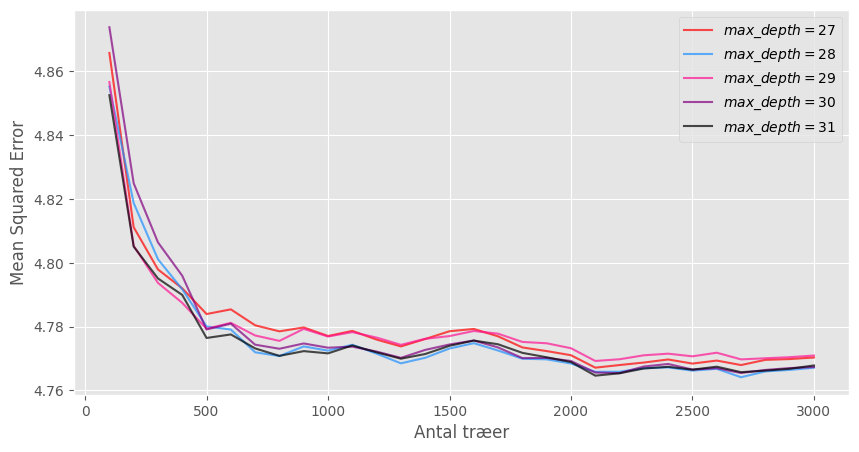

In [53]:
#rf_val_errors_df2.plot(figsize=(18, 3))

n_trees = np.arange(100,3100,100).tolist()
plt.figure(figsize=(10,5))
plt.plot(n_trees,rf_eval.iloc[:,5], 'red',alpha = 0.7, linestyle = '-',label='$max\_depth = 27$')
plt.plot(n_trees, rf_eval.iloc[:,1], 'dodgerblue',alpha = 0.7, linestyle = '-',label='$max\_depth = 28$')
plt.plot(n_trees,rf_eval.iloc[:,2], 'deeppink',alpha = 0.7 , linestyle = '-',label='$max\_depth = 29$')
plt.plot(n_trees,rf_eval.iloc[:,3], 'purple',alpha = 0.7, linestyle = '-',label='$max\_depth = 30$')
plt.plot(n_trees,rf_eval.iloc[:,4], 'black',alpha = 0.7, linestyle = '-',label='$max\_depth = 31$')
#plt.plot(n_trees,rf_eval.iloc[:,5], 'blue',alpha = 0.7, linestyle = '-',label='$max\_depth = 31$')
#plt.plot(n_trees,rf_eval.iloc[:,6], 'black',alpha = 0.7, linestyle = '-',label='$max\_depth = 32$')
plt.legend()
plt.xlabel("Antal træer")
plt.ylabel("Mean Squared Error")

In [56]:
rf_eval.min(axis=0)

Unnamed: 0      100.000000
max depth 28      4.764156
max depth 29      4.769242
max depth 30      4.765446
max depth 31      4.764647
max depth 27      4.767152
dtype: float64

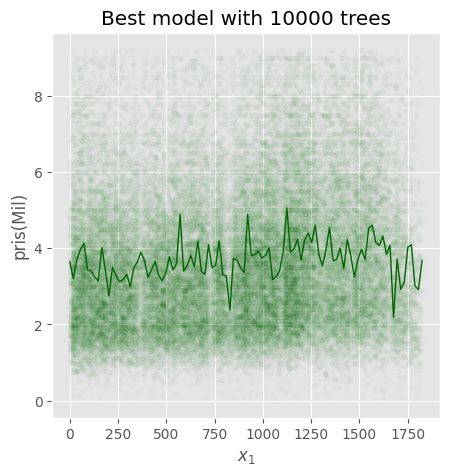

In [97]:
np.random.seed(7)
df_random = df.sample(n=20000)
X = df['salgsdato'].values.reshape(-1,1)
y = df["pris"].values

# Train the best model with 55 trees on the full training set
best_gbr = RandomForestRegressor(n_estimators=20000, max_depth=60, random_state=19)
best_gbr.fit(X_train_n, y_train_n)

# Plot the predictions of the best model against the true values
X_new_t = np.linspace(X_train_n.min(), X_train_n.max(), 400).reshape(400, 1)
y_pred = best_gbr.predict(X_new_t)
#x_value = np.linspace(X['salgsdato'].min(), X['salgsdato'].max(), 100).reshape(100, 1)
plt.figure(figsize=(5, 5))
plt.plot(X_train_n, y_train_n, ".", alpha=0.01, color='green')
plt.plot(X_new_t, y_pred, "-", linewidth=1, color='darkgreen')
plt.xlabel("$x_1$")
plt.ylabel("pris(Mil)")
#plt.xlim([200,1800])
#plt.ylim([0,12])
#plt.legend(loc="upper left")
plt.title("Best model with 10000 trees")
plt.show()

### Partial dependence Plot

In [11]:
X = df.drop(["pris","pris_natural_log"], axis=1)
y = df["pris_natural_log"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=19)

# Opret og træn en random forest model
xgb = RandomForestRegressor(n_estimators=1600, max_depth=31,random_state=19)
xgb.fit(X_train, y_train)


RandomForestRegressor(max_depth=31, n_estimators=1600, random_state=19)

<Figure size 1000x500 with 0 Axes>

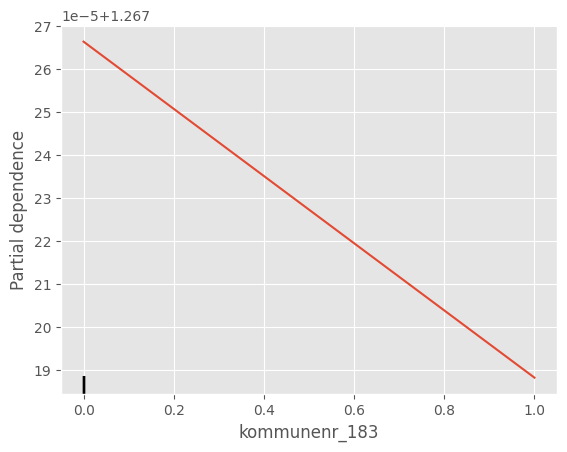

In [39]:
plt.figure(figsize=(10,5))
PartialDependenceDisplay.from_estimator(xgb, X_train, ['kommunenr_183'])

<Figure size 1000x500 with 0 Axes>

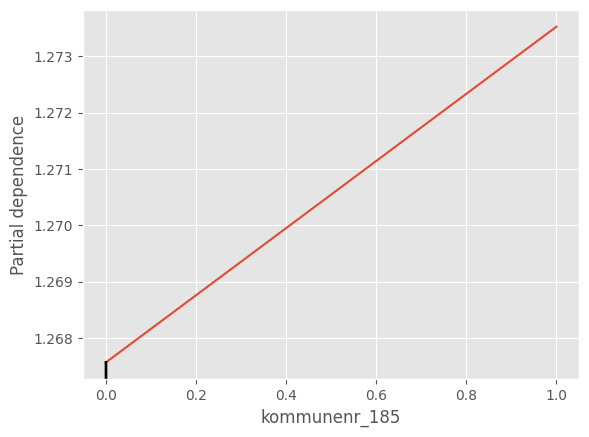

In [40]:
plt.figure(figsize=(10,5))
PartialDependenceDisplay.from_estimator(xgb, X_train, ['kommunenr_185'])

<Figure size 1000x500 with 0 Axes>

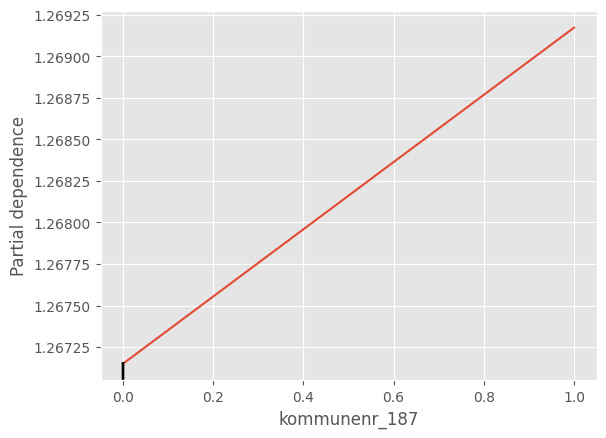

In [41]:
plt.figure(figsize=(10,5))
PartialDependenceDisplay.from_estimator(xgb, X_train, ['kommunenr_187'])

In [214]:
# Definer din model (vi bruger RandomForestRegressor som eksempel)
model = XGBRegressor(max_depth = 8, n_estimators=1000, learning_rate=0.1,random_state=19)

# Træn modellen på træningssættet
model.fit(X_train, y_train)

# Beregn præstationen på testsættet
y_pred = model.predict(X_val)
mse_test = mean_squared_error(y_val, y_pred)
r2_test = r2_score(y_val, y_pred)

# Udfør krydsvalidering (for eksempel 5-fold krydsvalidering) på træningssættet
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Beregn gennemsnitlig MSE for krydsvalidering og konverter til positiv værdi
mse_cv = -np.mean(cv_scores)

# Udskriv resultaterne
print(f"Test MSE: {mse_test:.5f}")
print(f"Cross-Validation MSE: {mse_cv:.5f}")
print(f"Test R^2: {r2_test:.5f}")

Test MSE: 0.09008
Cross-Validation MSE: 0.08965
Test R^2: 0.76690


In [256]:
# Definer din model (vi bruger RandomForestRegressor som eksempel)
model = GradientBoostingRegressor(max_depth = 8, n_estimators=600, learning_rate=0.1,random_state=19)

# Træn modellen på træningssættet
model.fit(X_train, y_train)

# Beregn præstationen på testsættet
y_pred = model.predict(X_val)
mse_test = mean_squared_error(y_val, y_pred)
r2_test = r2_score(y_val, y_pred)

# Udfør krydsvalidering (for eksempel 5-fold krydsvalidering) på træningssættet
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Beregn gennemsnitlig MSE for krydsvalidering og konverter til positiv værdi
mse_cv = -np.mean(cv_scores)

# Udskriv resultaterne
print(f"Test MSE: {mse_test:.5f}")
print(f"Cross-Validation MSE: {mse_cv:.5f}")
print(f"Test R^2: {r2_test:.5f}")

Test MSE: 0.09028
Cross-Validation MSE: 0.09088
Test R^2: 0.76639


In [311]:
# Definer din model (vi bruger RandomForestRegressor som eksempel)
model = RandomForestRegressor(max_depth = 31, n_estimators=1600,random_state=19)

# Træn modellen på træningssættet
model.fit(X_train, y_train)

# Beregn præstationen på testsættet
y_pred = model.predict(X_val)
mse_test = mean_squared_error(y_val, y_pred)
r2_test = r2_score(y_val, y_pred)

# Udfør krydsvalidering (for eksempel 5-fold krydsvalidering) på træningssættet
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Beregn gennemsnitlig MSE for krydsvalidering og konverter til positiv værdi
mse_cv = -np.mean(cv_scores)

# Udskriv resultaterne
print(f"Test MSE: {mse_test:.5f}")
print(f"Cross-Validation MSE: {mse_cv:.5f}")
print(f"Test R^2: {r2_test:.5f}")

Test MSE: 0.09596
Cross-Validation MSE: 0.09633
Test R^2: 0.75169


In [150]:
0.07361-0.06443

0.009179999999999994